# Kolmogorov DeepSolver
In this notebook we demonstrate a method for solving high-dimensional Kolmogorov partial differential equations (PDEs) that uses a deep neural network in conjunction with the Feynman-Kac connection.

We present a class-based implementation of the procedure described in [Jan Blechschmidt's notebook](https://github.com/janblechschmidt/PDEsByNNs/blob/main/Feynman_Kac_Solver.ipynb),
which in turn seeks to reproduce the results from the paper

- [Beck, Christian et al. *Solving stochastic differential equations and Kolmogorov equations by means of deep learning*, 2021.](https://link.springer.com/article/10.1007/s10915-021-01590-0)

and the [associated source code](https://github.com/seb-becker/kolmogorov).

<a href="https://colab.research.google.com/drive/1RawBUrWgVJI7YoljbOhZn3DAgWEQ4lZH?usp=sharing" target="_parent">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Introduction
A central challenge faced by numerical algorithms used to approximate PDE solutions is the curse of dimensionality.
In recent times, techniques from deep learning have proved to be successful in high-dimensional settings such as computer vision and natural language processing.
Consequently it has been conjectured that neural network-based approaches may provide a means of overcoming the curse of dimensionality in the approximation of high-dimensional PDE solutions.

Kolmogorov PDEs arise from the backward Kolmogorov equation associated with an Itô diffusion.
Such PDEs find applications in various disciplines, including the natural sciences, engineering and finance.
Kolmogorov PDEs are typically only numerically tractable and the design of methods that approximate their solutions remains an active area of research.
The approximation methods in the literature tend to either be based on deterministic techniques such as finite differences ([Kushner, (1976)](https://www.sciencedirect.com/science/article/pii/0022247X76901098), [Brennan, Schwartz (1978)](https://www.jstor.org/stable/2330152))
and finite elements ([Brenner, Scott (1996)](https://books.google.co.nz/books/about/The_Mathematical_Theory_of_Finite_Elemen.html?id=YhPJf_4pu8kC&redir_esc=y)),
or stochastic techniques based on Monte Carlo methods ([Graham, Talay (2013)](https://books.google.co.nz/books/about/Stochastic_Simulation_and_Monte_Carlo_Me.html?id=jyG4BAAAQBAJ&redir_esc=y)).
Whilst the former suffers from the curse of dimensionality, the latter only approximates solutions at a fixed space-time point.
The approximation scheme implemented in this notebook aims to overcome both of these limitations, providing a numerical approximation of the solution of a Kolmogorov PDE on a hypercube $[a,b]^d\subset\mathbb{R^d}$ for large $d$.

## Conceptual overview
We wish to solve the parabolic problem

$$
\begin{align}
\partial_tu + \frac{1}{2}{\rm Tr}(\sigma\sigma^{\mathsf T}\, {\bf H}_xu) + \mu\cdot\nabla u &= 0 \\ \nonumber
u(T,\cdot) & = g,
\end{align}
$$

where
- $T>0$,
- $\mu\colon [0,T]\times\mathbb{R^d}\to\mathbb{R^d}$
and $\sigma\colon [0,T]\times\mathbb{R^d}\to\mathbb{R^{d\times d}}$
are globally Lipschitz continuous,
- $g\colon\mathbb{R^d}\to\mathbb{R}$ is a function,
- ${\bf H}_xu$ is the Hessian matrix associated with $u$.

The algorithm proposed in [Beck et al. (2021)](https://link.springer.com/article/10.1007/s10915-021-01590-0) proceeds as follows.
First the PDE is reformulated in terms of an infinite dimensional stochastic optimisation problem. This problem is then temporally discretised via a suitable discretisation of the associated stochastic differential equation (SDE) and spatially discretised using a fully-connected feedforward neural network.
The resulting finite dimensional stochastic optimisation problem is then solved using stochastic gradient descent-type algorithms.

The proposed approximation scheme rests on our ability to identify solutions of Kolmogorov PDEs with solutions of infinite dimensional stochastic optimisation problems.
The basis for doing so is provided at [Beck et al. (2021)](https://link.springer.com/article/10.1007/s10915-021-01590-0) Proposition 1.1.
We summarise a version of this result.

Consider a probability space $(\Omega,\mathcal{F},\mathbb{P})$ and let $W\colon[0,T]\times\Omega\to\mathbb{R^d}$ be a standard Brownian motion with natural filtration $\mathbb{F} = (\mathcal{F}^W_t)_{t\in[0,T]}$.
Let $\xi\colon\Omega\to\mathcal{D}$ be a continuous uniformly distributed
$\mathcal{F}_0$-measurable random variable.
Suppose that $X=(X_t)_{t\in[0,T]}$ is an $\mathbb{F}$-adapted stochastic process on $\Omega$
with continuous paths and satisfies

$$
X_t = \xi + \int^t_0 \mu(s, X_s)\, {\rm d}s + \int^t_0 \sigma(s, X_s)\, {\rm d}W_s
$$

$\mathbb{P}$-a.s for all $t\in[0,T]$.
Then there exists a unique continuous function $U\colon\mathcal{D}\to\mathbb{R}$ such that

$$
\mathbb{E}[|g(X_T) - U(\xi)|^2]
= \inf_{v\in C(\mathcal{D})} \mathbb{E}[|g(X_T) - v(\xi)|^2].
$$

Moreover, $U(x) = u(T,x)$ for all $x\in \mathcal{D}$.

In this way we may recast the Kolmogorov PDE $(1)$ in terms of a stochastic optimisation problem.

It remains to discretise the process $X$ and approximate the map $x\mapsto U(x)=u(T,x)$ on $\mathcal{D}$.
We consider the discretisation $\widetilde X = (\widetilde X_n)^N_{n=0}$ of $X$ in the next section where we discuss the generation of training data.
Regarding the approximation of $u$ at time $T$,
we define an artificial neural network
$\mathbb{U}\colon\mathbb{R^\nu}\times\mathbb{R^d}\to\mathbb{R}$ such that

$$
\mathbb{U}(\theta,x)\approx u(T,x)
$$

for all $x\in\mathcal{D}$, for "suitable" $\theta\in\mathbb{R^\nu}$.
Since by the Feynman-Kac formula one has that

$$
u(t,x) = \mathbb{E}[g(X_T)|X_t=x]
$$

for all $t\in[0,T]$ and $x\in\mathcal{D}$, we obtain "suitable" $\theta$ by minimising the map

$$
\theta \mapsto \mathbb{E}[|g(\widetilde X_N) - \mathbb{U}(\theta,\xi)|^2]
$$

using a stochastic gradient descent-type algorithm.




## Solution method
Note that by the change of variable $t\mapsto T-t$ one obtains the initial-value version

$$
\begin{aligned}
\partial_tu - \frac{1}{2}{\rm Tr}(\sigma\sigma^{\mathsf T}\, {\bf H}_xu) - \mu\cdot\nabla u &= 0 \\
u(0,\cdot) & = g
\end{aligned}
$$

of the Kolmogorov PDE $(1)$.
We shall approximate the map $x\mapsto u(t,x)$ on $\mathcal{D}$ at $t=0$.

The implementation of the proposed approximation scheme comprises two steps:

1. The generation of training data by sampling paths for the process $(X_t)_{t\in[t_0,T]}$.
2. The training of the neural network approximation $\mathbb{U}(\theta,\cdot)$ of $u(0,\cdot)$.

### Step 1: Generating the training data
The training data consists of pairs $(x_i,y_i)$ with $x_i\sim U(\mathcal{D})$
and $y_i = g(X_T)$,
where

$$
X_T = x_i + \int^T_0 \mu(s, X_s)\, {\rm d}s + \int^T_0 \sigma(s, X_s)\, {\rm d}W_s.
$$

Hence each sample path starts at a uniformly randomly drawn point in $\mathcal{D}$.
The way in which we draw realisations of $X_T$ depends on whether or not its distribution is available in closed form.

#### Simple case: Distribution of $X_T$ is available in closed form
In this situation we may draw pairs $(x_i, y_i)$ directly.
For example, if $\mu=0$ and $\sigma$ is constant, the solution process is given by

$$
X_t = x + \sigma W_t, \quad t\in[0,T].
$$

Hence we may draw $x_i \sim U(\mathcal{D})$ and set $y_i = g(x_i + \sqrt{T} \sigma \xi)$,
where $\xi \sim N(0,I_{d\times d})$.

#### General case: Distribution of $X_T$ is not available in closed form
In this situation we use the Euler-Maruyama scheme in order to (temporally) discretise
the process $X$ as follows.

Let $N\in\mathbb{N}$ and let $t_0,t_1,\ldots,t_N\in[0,\infty)$ be such that
$0=t_0<t_1<\ldots<t_N=T$.
Then

$$
X_{t_{n+1}} = X_{t_{n}} + \int^{t_{n+1}}_{t_n}\mu(s,X_s){\rm d}s
+ \int^{t_{n+1}}_{t_n}\sigma(s,X_s){\rm d}W_s
$$

for all $n\in\{0,1,\ldots,N-1 \}$, $\mathbb{P}$-a.s.

Hence for sufficiently small mesh size $\sup|t_{n+1}-t_n|$,
one has that

$$
X_{t_{n+1}} \approx X_{t_{n}} + \mu(t_n,X_{t_{n}})(t_{n+1}-t_n)
+ \sigma(t_n,X_{t_{n}})(W_{t_{n+1}}-W_{t_n})
$$

for all $n\in\{0,1,\ldots,N-1 \}$, $\mathbb{P}$-a.s.

Let $(\widetilde X_n)^N_{n=0}$ be the stochastic process such that $X_0\sim U(\mathcal{D})$ and

$$
\widetilde X_{n+1} = \widetilde X_n
+ \mu(t_n, \widetilde X_n)(t_{n+1}-t_n)
+ \sigma(t_n, \widetilde X_n)(W_{t_n+1}-W_{t_n})
$$

for all $n\in\{0,1,\ldots,N-1 \}$.
Then $\widetilde X_n \approx X_{t_n}$ for all $n\in\{0,1,\ldots,N\}$.

We then set $x_i=X_0$ and $y_i = g(\widetilde X^i_N)$,
where $\{(\widetilde X^i_{n})^N_{n=0}\}^{n_{samples}}_{i=1}$
is a family of paths simulated according to the above scheme.

Note: Strong convergence results for the Euler-Maruyama scheme (cf. [Kloeden, Platen (1992)](https://www.springer.com/de/book/9783540540625)) ensure that $\widetilde X_n \to X_{t_n}$ pathwise as $N \to \infty$ and $\sup |t_{n+1} - t_{n}| \to 0$.

### Step 2: Neural network approximation

We approximate the mapping $x\mapsto u(0,x)$ on $\mathcal{D}$ using a fully-connected feedforward artificial neural network $\mathbb{U(\theta,\cdot)}$ with the following structure given in [Beck et al. (2021)](https://link.springer.com/article/10.1007/s10915-021-01590-0):

    Input -> BN -> (Dense -> BN -> TanH) -> (Dense -> BN -> TanH) -> Dense -> BN -> Output

Here, `BN` denotes Batch Normalization (see [Ioffe, Szegedy (2015)](https://proceedings.mlr.press/v37/ioffe15.html)), `Dense` a fully connected layer **without** bias term and activation and `TanH` the componentwise hyperbolic tangent activation function

$$
\tanh\colon x \mapsto  \frac{e^x - e^{-x}}{e^x + e^{-x}}.
$$

All weights in the neural network are initialised by means of Xavier initialisation (see [Glorot, Bengio (2010)](https://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)).


Given a batch of observations $\{(x_i,y_i)\}^m_{i=1}$,
we train the network by minimising the mean square error (MSE) loss

$$
\ell(\theta) = \frac{1}{m}\sum^m_{i=1}|y_i - \mathbb{U(\theta,x_i)}|^2.
$$

We use TensorFlow's automatic differentiation functionality in order to compute the gradient of $\ell$ with respect to the parameter vector $\theta$ of `trainable_variables`.

The overall error of the proposed approximation scheme stems from three sources:
- Approximation error - this measures how well the exact solution of the Kolmogorov PDE may be represented by a neural network of a given architecture (see e.g. [Grohs et. al. (2018)](https://arxiv.org/abs/1809.02362), [Elbrächter et. al. (2021)](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9363169), [Kutyniok et. al. (2022)](https://link.springer.com/article/10.1007/s00365-021-09551-4))

- Statistical/generalisation error - this measures how well the exact distributions of solutions of SDEs associated with Kolmogorov PDEs are reflected by approximative sampling from the corresponding SDEs (see e.g. [Berner et. al. (2020)](https://epubs.siam.org/doi/10.1137/19M125649X))

- Optimisation error - this measures how close the output of the employed optimisation algorithm gets to the exact solution of the approximative optimisation problem. Whilst this source of error is well studied in the case of a convex objective function, in the non-convex setting the investigation of optimisation error remains a topic of future research.


As in [Beck et al. (2021)](https://link.springer.com/article/10.1007/s10915-021-01590-0) we compute the relative $L_1$, $L_2$ and $L_\infty$-errors of our approximation during training.
That is, we compute

$$
\frac{1}{|\mathcal{D}|}\int_\mathcal{D}\Big|\frac{u(0,x) - \mathbb{U}(\theta,x)}{u(0,x)}\Big|\,{\rm d}x
$$

the relative $L_1$-error over $\mathcal{D}$,

$$
\Bigg(\frac{1}{|\mathcal{D}|}\int_\mathcal{D}\Big|\frac{u(0,x) - \mathbb{U}(\theta,x)}{u(0,x)}\Big|^2\,{\rm d}x\Bigg)^{1/2}
$$

the relative $L_2$-error over $\mathcal{D}$ and

$$
\sup_{x\in\mathcal{D}}\Big|\frac{u(0,x) - \mathbb{U}(\theta,x)}{u(0,x)}\Big|
$$

the relative $L_\infty$-error over $\mathcal{D}$.


## Implementation walkthrough
In order to illustrate each step of the proposed approximation scheme,
we first implement the algorithm in a didactic manner.
We shall solve the heat equation as formulated in Example 4.2 of [Beck et al. (2021)](https://link.springer.com/article/10.1007/s10915-021-01590-0).
In the next section we present a class-based implementation of the algorithm, which we then apply to other examples.

*It is recommended to run this notebook in Google Colab with GPU acceleration enabled.*

<a href="https://colab.research.google.com/drive/1RawBUrWgVJI7YoljbOhZn3DAgWEQ4lZH?usp=sharing" target="_parent">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

### 1. Initialise the problem
The code runs with TensorFlow version 2.12.0.

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.plotting.register_matplotlib_converters()

from abc import abstractmethod
from mpl_toolkits.mplot3d import Axes3D
from time import time

# Set data type
DTYPE='float32'
#DTYPE='float64'
tf.keras.backend.set_floatx(DTYPE)
print('TensorFlow version used: {}'.format(tf.__version__))

TensorFlow version used: 2.12.0


We wish to solve the heat equation in 100 spatial dimensions.
We assume that $\mu=0$, $\sigma=\sqrt{2}$ and $g=\|\cdot\|^2$,
which corresponds to the PDE

$$
\begin{aligned}
\partial_tu(t,x) &= \Delta u(t,x) \\
u(0,x) &= \|x\|^2.
\end{aligned}
$$

We approximate the solution

$$
u(t,x) = \|x\|^2 + 2td
$$

on $\mathcal{D} = [0,1]^d$ for $d=100$.

We begin by setting the following problem-specific data.

In [ ]:
# Final time
T = tf.constant(1., dtype=DTYPE)

# Spatial dimension
dim = 100

# Spatial domain of interest at t=0
a = np.zeros(dim, dtype=DTYPE)
b = np.ones(dim, dtype=DTYPE)

# Diffusion term (assumed constant)
sigma = tf.sqrt(tf.constant(2, dtype=DTYPE))

# Initial condition
def g(x):
    return tf.reduce_sum(tf.pow(x,2), axis=1, keepdims=True)

# Exact solution, for reference
def u(t, x):
    return tf.reduce_sum(tf.pow(x,2), axis=1, keepdims=True) + 2 * t * dim

### 2. Generate the training data
Since we know the distribution of $X_T$, it suffices to let $X_0\sim U(\mathcal{D})$ and set

$$
y = g(X_0 + \sigma\sqrt{T}\xi),
$$

where $\xi\sim N(0, I_{d\times d})$.

Note that we use the `@tf.function` decorator where possible in order to minimise training time.

In [ ]:
@tf.function
def draw_X(num_samples):
    """ Draws `num_samples` pairs of starting values X_0
    and end points X_T of a stochastic process X with zero drift and
    constant scalar diffusion. Starting points are drawn uniformly from the
    hypercube [a,b]^d \subset \mathbb{R}^d.
    """
    X0 = a + tf.random.uniform((num_samples, dim), dtype=DTYPE) * (b-a)
    xi = tf.random.normal((num_samples, dim), dtype=DTYPE)
    XT = X0 + sigma * tf.sqrt(T) * xi

    # Return simulated paths
    return tf.stack([X0, XT], 2)

### 3. Define the neural network model

Next we define a fully-connected feedforward artificial neural network $\mathbb{U(\theta,\cdot)}$ with the structure

    Input -> BN -> (Dense -> BN -> TanH) -> (Dense -> BN -> TanH) -> Dense -> BN -> Output

as described in the previous section.
We will use this mapping to approximate the solution $u$ of the heat equation on $\mathcal{D} = [0,1]^{100}$ at time $t=0$.


In [ ]:
def init_model(dim, activation='tanh',
               num_hidden_neurons=100,
               num_hidden_layers=2):
    """ Constructs the neural network,
    default arg values correspond to the architecture specified in Beck et al.
    """
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(dim))
    model.add(tf.keras.layers.BatchNormalization(epsilon=1e-6))

    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_hidden_neurons,
                                        activation=None,
                                        use_bias=False,
                                        kernel_initializer=tf.keras.initializers.GlorotUniform()))
        model.add(tf.keras.layers.BatchNormalization(epsilon=1e-6))
        model.add(tf.keras.layers.Activation(activation))

    model.add(tf.keras.layers.Dense(1,
                                    activation=None,
                                    use_bias=False,
                                    kernel_initializer=tf.keras.initializers.GlorotUniform()))
    model.add(tf.keras.layers.BatchNormalization(epsilon=1e-6))
    return model

### 4. Define the loss function
Since by the Feynman-Kac formula we have that $u(0,x) = \mathbb{E}[g(X_T)|X_0=x]$,
we minimise the mean square error (MSE)

$$
\ell(\theta) = \mathbb{E}\big[|g(X_T) - \mathbb{U}(\theta,x)|^2\big]
$$

in order to obtain that $\mathbb{U(\theta,\cdot)}\approx u(0,\cdot)$.

Given a batch of observations $\{(x^i,y^i)\}^m_{i=1}$
we approximate the MSE by the sample mean

$$
\ell(\theta)\approx\frac{1}{m}\sum^m_{i=1}|y^i - \mathbb{U}(\theta,x^i)|^2,
$$

where $x^i = X^i_0\sim U(\mathcal{D})$ and $y^i=g(X^i_T)$.

In [ ]:
def loss_fn(X, y, model, training=False):
    """ Computes the mean squared error between the current model
    prediction model(X) and the values y.
    Inputs:
        X - approximation of the state process X
        y - target value
        model - neural network approximating the map x -> u(0,x) on D
        training - boolean flag to indicate training
    """
    X0 = X[:,:,0]
    y_pred = model(X0, training)

    # Return MSE
    return tf.reduce_mean(tf.math.squared_difference(y, y_pred))

We use TensorFlow's autodiff functionality in order to compute the gradient of the loss function $\ell$ with respect to the parameter vector $\theta$ of `trainable_variables`.

In [ ]:
@tf.function
def compute_grad(X, y, model, training=False):
    """ Computes the gradient of the loss function w.r.t. theta.
    Inputs:
        X - approximation of the state process X
        y - target value
        model - model of neural network approximating the map x -> u(0,x) on D
        training - boolean flag to indicate training
    """
    with tf.GradientTape() as tape:
        loss = loss_fn(X, y, model, training)

    grad = tape.gradient(loss, model.trainable_variables)
    return loss, grad

Finally we compose the functions `draw_X` and `compute_grad` using `train_step`, which carries out one training step on a sample of size `batch_size` and returns the loss incurred by the model.

In [ ]:
@tf.function
def train_step(batch_size):
    """ Draws a training set (X,y) of size batch_size and performs one training step
    """
    # Draw a sample of state paths
    X = draw_X(batch_size)

    # Evaluate g(X_T)
    y = g(X[:,:,-1])

    # Compute loss, grad
    loss, grad = compute_grad(X, y, model, training=True)

    # Perform gradient step
    optimiser.apply_gradients(zip(grad, model.trainable_variables))
    return loss

### 5. Solve the PDE
We may now initialise the model, select an optimiser and learning rate schedule, and define a test set against which we measure the $L_p$-errors of the model.

In [ ]:
model = init_model(dim=dim, num_hidden_neurons=200)
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([250001,500001],[1e-3,1e-4,1e-5])
optimiser = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=1e-8)

n_test = 1000000
X = draw_X(n_test)
Xtest = X[:,:,0]
Ytest = u(T, Xtest)

Next we train the model.

In [ ]:
num_epochs = 750001
batch_size = 8192

loss_history = []
history = []

# Set interval at which the L_p-errors are recorded
log_interval = 1000

# Initialise output header
print(' Iter    |     Loss        L1_rel   L2_rel   Linf_rel   |     Stepsize     Runtime')

# Start timer
t0 = time()

# Loop to train model
for i in range(num_epochs):

    # Perform training step
    loss = train_step(batch_size)
    loss_history.append(loss)

    if i % log_interval == 0:
        Ypred = model(Xtest, training=False)

        abs_error = tf.abs(Ypred - Ytest)
        rel_error = abs_error/Ytest

        L2_abs = tf.sqrt(tf.reduce_mean(tf.pow(abs_error, 2)))
        L1_abs = tf.reduce_mean(tf.abs(abs_error))
        Linf_abs = tf.reduce_max(tf.abs(abs_error))

        L2_rel = tf.sqrt(tf.reduce_mean(tf.pow(rel_error, 2)))
        L1_rel = tf.reduce_mean(tf.abs(rel_error))
        Linf_rel = tf.reduce_max(tf.abs(rel_error))

        runtime = time() - t0
        stepsize = optimiser.lr.numpy()
        hentry = (i, loss, L1_rel, L2_rel, Linf_rel, L1_abs, L2_abs, Linf_abs, stepsize, runtime)
        history.append(hentry)
        print(f'{i:5d}\t |{loss:12.4f}   {L1_rel:8.4f} {L2_rel:8.4f}  {Linf_rel:8.4f}\t|     {stepsize:6.2e}     {runtime:6.1f}')
print(time() - t0)

We plot the loss incurred by the model during training, as well as the relative $L_p$-errors over $\mathcal{D}$.

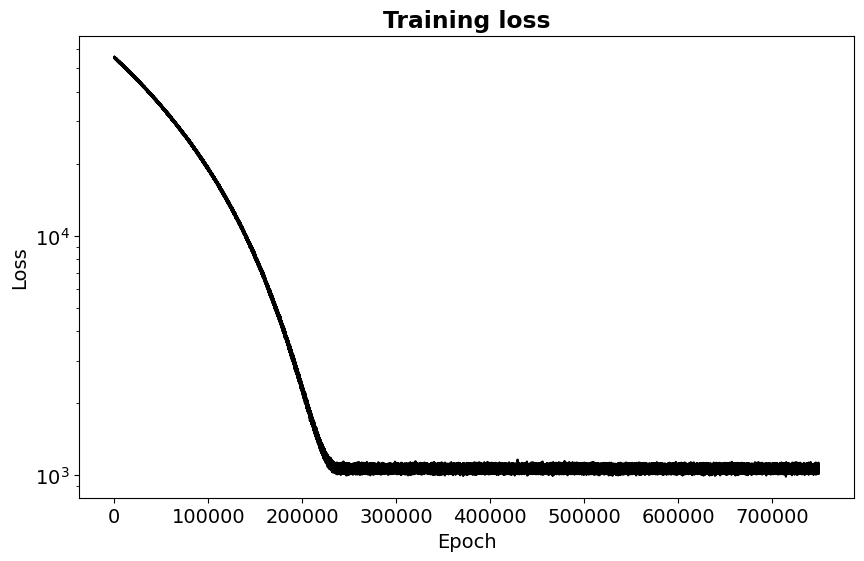

In [ ]:
#@title
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.semilogy(range(len(loss_history)), loss_history,'k-')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training loss', weight='bold');

In [ ]:
#@title
fig, ax = plt.subplots(1,1, figsize=(9,6))
ax.set_prop_cycle(color=['royalblue', 'darkorange', 'darkcyan'])
start_idx = 0
xrange = [h[0] for h in history[start_idx:]]
ax.semilogy(xrange, [h[2:5] for h in history[start_idx:]])
ax.set_xlabel('Epoch')
ax.set_ylabel('Error')
ax.set_title('Training error', weight='bold')
ax.legend(['$L_1$', '$L_2$', '$L_{\infty}$']);

Next we compare our results with those for the corresponding example from [Beck et al. (2021)](https://link.springer.com/article/10.1007/s10915-021-01590-0) (Example 4.2).

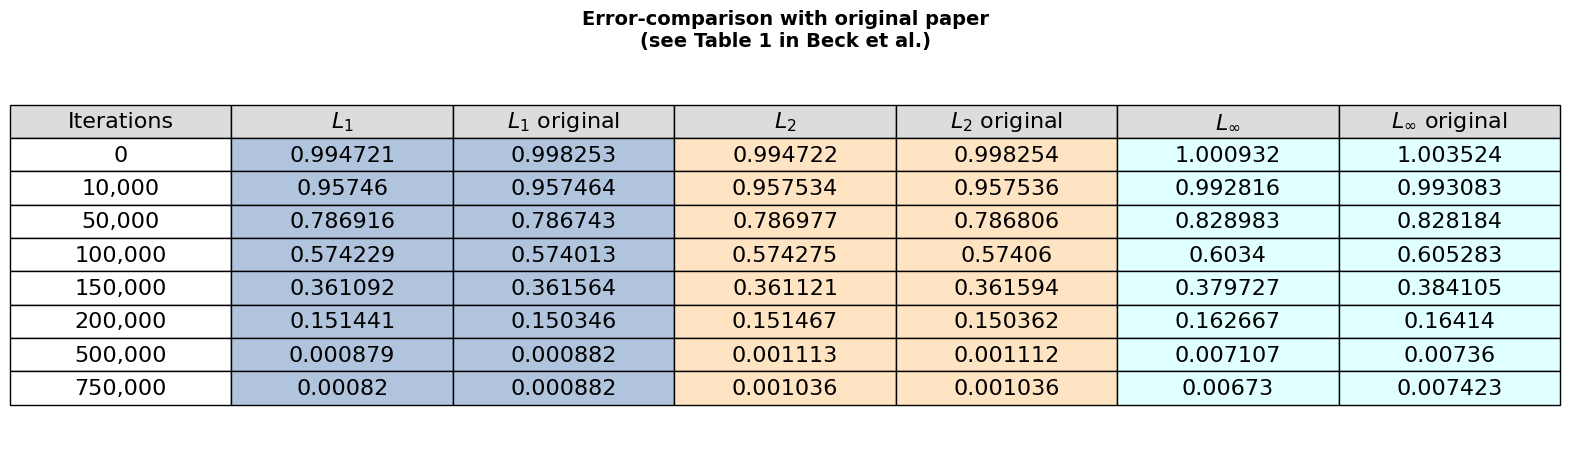

In [ ]:
#@title
history = np.asarray(history)

errors = history[:,[0,2,3,4]][[0,10,50,100,150,200,500,750],:]
errors[:,0] = errors[:,0]

column_headers = ('Iterations', r'$L_1$', r'$L_1$ original', r'$L_2$', r'$L_2$ original',r'$L_\infty$', r'$L_\infty$ original')

df = pd.DataFrame(index=errors[:,0], columns=column_headers)
df[df.columns[0]] = errors[:,0]
df[df.columns[0]] =  df[df.columns[0]].astype(pd.Int32Dtype())
df[df.columns[0]] = df.apply(lambda x: "{:,}".format(x['Iterations']), axis=1)
df[df.columns[1]] = errors[:,1].round(decimals=6)
df[df.columns[2]] = np.asarray([0.998253, 0.957464, 0.786743, 0.574013, 0.361564, 0.150346, 0.000882, 0.000882]) # L1 errors from Table 1 in Beck et al.
df[df.columns[3]] = errors[:,2].round(decimals=6)
df[df.columns[4]] = np.asarray([0.998254, 0.957536,0.786806, 0.574060, 0.361594, 0.150362,  0.001112, 0.001036]) # L2 errors from Table 1 in Beck et al.
df[df.columns[5]] = errors[:,3].round(decimals=6)
df[df.columns[6]] = np.asarray([1.003524, 0.993083, 0.828184, 0.605283, 0.384105, 0.164140, 0.007360, 0.007423]) # L\infty errors from Table 1 in Beck et al.

fig, ax1 = plt.subplots(figsize=(20, 2 + errors.shape[0] / 2.5))

headcolours = np.full(len(column_headers), 'gainsboro')
colcolours = ['w','lightsteelblue','lightsteelblue','bisque','bisque','lightcyan','lightcyan']
cellcolours = [colcolours for _ in range(8)]
table = ax1.table(cellText=df.values,
                  cellLoc='center',
                  cellColours=cellcolours,
                  rowLoc='center',
                  colLabels=column_headers,
                  colColours=headcolours,
                  loc='center')
table.scale(1, 2)
table.set_fontsize(16)
ax1.axis('off')
title = 'Error-comparison with original paper'
subtitle = 'see Table 1 in Beck et al.'
ax1.set_title(f'{title}\n({subtitle})', weight='bold', size=14, color='k');

Finally we plot a slice of our approximate solution $\mathbb{U}(\theta,\cdot)$ over two input dimensions, as well as the pointwise relative error.

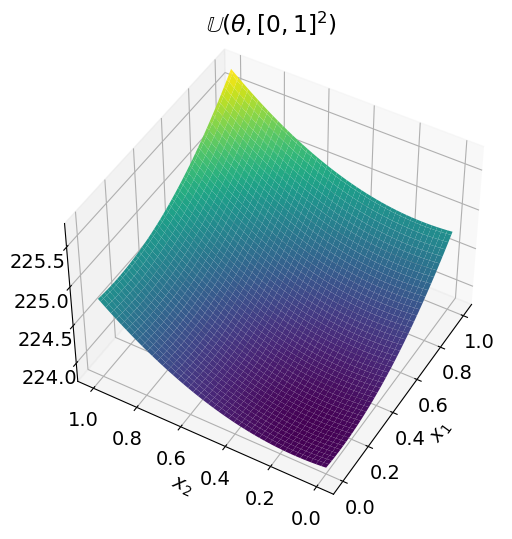

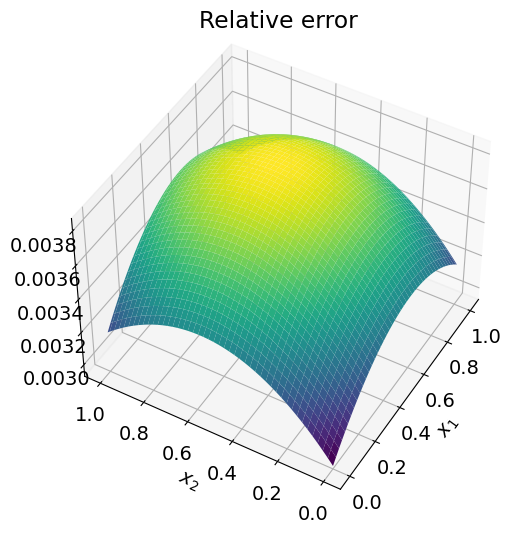

In [ ]:
#@title
n_grid = 400

idx0 = 0
idx1 = 1

idx = np.arange(dim)
idx_remaining = np.setdiff1d(idx, [idx0, idx1])
val_remaining = (a+b)/2

xspace = np.linspace(a[idx0], b[idx0], n_grid + 1, dtype=DTYPE)
yspace = np.linspace(a[idx1], b[idx1], n_grid + 1, dtype=DTYPE)
X, Y = np.meshgrid(xspace, yspace)

Z = np.repeat(val_remaining[idx_remaining].reshape(1,-1), (n_grid + 1) ** 2, axis=0)
Xgrid = np.vstack([X.flatten(), Y.flatten()]).T
Xgrid = np.hstack([Xgrid, Z])

u_theta = model(Xgrid, training=False).numpy().reshape(n_grid+1,n_grid+1)
rel_error = tf.abs(model(Xgrid, training=False) - u(T, Xgrid)) / u(T, Xgrid)
rel_error = rel_error.numpy().reshape(n_grid+1,n_grid+1)

fig = plt.figure(figsize=(11,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, u_theta, cmap='viridis')
ax.view_init(45,210)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title(r'$\mathbb{U}(\theta,[0,1]^2)$')

fig = plt.figure(figsize=(11,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, rel_error, cmap='viridis')
ax.view_init(45,210)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('Relative error');

## Class-based implementation
In this section we implement the approximation scheme in terms of a class-based structure.
We then demonstrate its usage by solving the heat and Black Scholes equations as formulated in Examples 4.2, 4.3 and 4.4 in [Beck et al. (2021)](https://link.springer.com/article/10.1007/s10915-021-01590-0).

We define a base class `KolmogorovSolver` that inherits from `tf.keras.Model` and encapsulates the algorithm outlined above.
The final problem-specific solver is then obtained by subclassing and defining problem-specific methods for the state space dynamics and terminal condition.

<a href="https://colab.research.google.com/drive/1RawBUrWgVJI7YoljbOhZn3DAgWEQ4lZH?usp=sharing" target="_parent">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
class KolmogorovSolver(tf.keras.Model):
    def __init__(self, dim=100,
                 a_scalar=0,
                 b_scalar=1,
                 T=1.,
                 sigma=tf.sqrt(tf.constant(2, dtype=DTYPE)),
                 lr=tf.keras.optimizers.schedules.PiecewiseConstantDecay([250001,500001],[1e-3,1e-4,1e-5]),
                 **kwargs):

        super().__init__(**kwargs)

        self.a_scalar = a_scalar
        self.b_scalar = b_scalar
        self.dim = dim
        self.a = self.a_scalar * np.ones(self.dim, dtype=DTYPE)
        self.b = self.b_scalar * np.ones(self.dim, dtype=DTYPE)
        self.T = T
        self.N = 1
        self.sigma = sigma

        self.optimiser = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=1e-8)
        self.model = self._construct_model()

    @staticmethod
    def _construct_model(dim=100, num_hidden_layers=2, activation='tanh'):
        """ Constructs the neural network,
        default argument values correspond to the architecture specified in Beck et al.
        """
        # Template of dense layer without bias and activation
        _dense = lambda dim: tf.keras.layers.Dense(
              units=dim,
              activation=None,
              use_bias=False,
              kernel_initializer=tf.keras.initializers.GlorotUniform())

        # Template of batch normalisation layer
        _bn = lambda : tf.keras.layers.BatchNormalization(epsilon=1e-6)

        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Input(dim))
        model.add(_bn())

        for _ in range(num_hidden_layers):
            model.add(_dense(dim+100))
            model.add(_bn())
            model.add(tf.keras.layers.Activation(activation))

        model.add(_dense(1))
        model.add(_bn())
        return model

    def call(self, X, training=False):
        return self.model(X, training)

    # Terminal condition
    @abstractmethod
    @tf.function
    def g(self, x):
        pass

    @tf.function
    def _draw_X(self, num_samples):
        """ Draws num_samples pairs of starting values X_0
        and end points X_T of a stochastic process X with dynamics specified by _state_step. Starting points are drawn uniformly from the
        hypercube [a,b]^d \\subset \mathbb{R}^d.
        """
        X0 = self.a + tf.random.uniform((num_samples, self.dim), dtype=DTYPE) * (self.b-self.a)
        XT = self._state_step(num_samples, X0)
        return tf.stack([X0,XT],2)

    @tf.function
    def _mc_step(self, X, y, n_test, mc_samples, batch_size):
        """ Carries out one step through the state space for use in Monte Carlo methods
        """
        upd = self._state_step(batch_size, tf.ones(shape=(batch_size, self.dim)))
        XT = tf.reshape(X, shape=[n_test, self.dim, 1]) * tf.transpose(upd)
        return y + tf.reduce_sum(tf.reshape(self.g(XT), [n_test, batch_size]), axis=1, keepdims=True)/(batch_size * mc_samples)

    def u_ref(self, Xgrid):
        """Computes a reference soluion using Monte Carlo method
        """
        n_test = Xgrid.shape[0]
        mc_samples=2000
        batch_size = 512

        u_ref = tf.zeros((n_test,1),dtype=DTYPE)

        print('Computing Monte Carlo reference solution...')
        for i in range(mc_samples):
            if i%100==0:
                print(i,'/',mc_samples)
            u_ref = self._mc_step(Xgrid, u_ref, n_test, mc_samples, batch_size)

        return u_ref

    @tf.function
    def test_set_exact(self, n_test=1000000):
        """ Produces a test set in cases where the closed-form solution is available
        """
        Xtest =  self.a + tf.random.uniform((n_test, self.dim), dtype=DTYPE) * (self.b-self.a)
        Ytest =  self.u_ref(Xtest)
        return Xtest, Ytest

    def test_set_mc(self, n_test=250000, mc_samples=32000, batch_size=32):
        """ Produces a test set in cases where the closed-form solution is not available
        """
        X = self._draw_X(n_test)
        Xtest = tf.convert_to_tensor(X[:,:,0], dtype=DTYPE)
        Ytest = tf.zeros((Xtest.shape[0],1), dtype=DTYPE)

        for i in range(mc_samples):
            if i % 100 == 0:
                print(i, '/', mc_samples)
            Ytest = self._mc_step(Xtest, Ytest, n_test, mc_samples, batch_size)

        return Xtest, Ytest

    @tf.function
    def _loss_fn(self, X, y, training=False):
        """ Computes the mean squared error between the current model
        prediction model(X) and reference values y.
        Inputs:
            X - approximation to the state process X
            y - target value
            training - boolean flag to indicate training
        """
        X0 = X[:,:,0]
        y_pred = self.model(X0, training)
        return tf.reduce_mean(tf.math.squared_difference(y,y_pred))

    @tf.function
    def _compute_grad(self, X, y, training=False):
        """ Computes the gradient of the loss function w.r.t.
        the trainable variables theta.
        Inputs:
            X - approximation of the state process X
            y - target value
            training - boolean flag to indicate training
        """
        with tf.GradientTape() as tape:
            loss = self._loss_fn(X, y, training)

        grad = tape.gradient(loss, self.trainable_variables)
        return loss, grad

    @tf.function
    def _train_step(self, batch_size):
        """ Draws a training set (X,y) of size batch_size and performs one training step
        """
        X = self._draw_X(batch_size)
        y = self.g(X[:,:,-1])
        loss, grad = self._compute_grad(X, y, training=True)
        self.optimiser.apply_gradients(zip(grad, self.trainable_variables))
        return loss

    def _compute_errors(self, Xtest, Ytest):
        """ Computes the L1, L2 and Linf errors of the model relative to a test set
        """
        Ypred = self(Xtest, training=False)
        abs_error =tf.abs(Ypred - Ytest)
        rel_error = abs_error/Ytest

        L1_abs = tf.reduce_mean(tf.abs(abs_error))
        L2_abs = tf.sqrt(tf.reduce_mean(tf.pow(abs_error, 2)))
        Linf_abs = tf.reduce_max(tf.abs(abs_error))

        L1_rel = tf.reduce_mean(tf.abs(rel_error))
        L2_rel = tf.sqrt(tf.reduce_mean(tf.pow(rel_error, 2)))
        Linf_rel = tf.reduce_max(tf.abs(rel_error))
        return (L1_abs, L1_rel), (L2_abs, L2_rel), (Linf_abs, Linf_rel)

    def experiment(self, Xtest,
                   Ytest,
                   num_epochs=750001,
                   batch_size=8192,
                   log_interval=1000):
      """ Trains the model for num_epochs iterations on batches of size batch_size
      """
      loss_history = []
      history = []
      t0 = time()

      print(' Iter    |     Loss        L1_rel   L2_rel   Linf_rel   |     Stepsize     Runtime')

      for i in range(num_epochs):
          loss = self._train_step(batch_size)
          loss_history.append(loss)

          if i % log_interval == 0:
              L1, L2, Linf = self._compute_errors(Xtest, Ytest)
              runtime = time() - t0
              stepsize = self.optimiser.lr.numpy()
              hentry = (i, loss, L1[1], L2[1], Linf[1], L1[0], L2[0], Linf[0], stepsize, runtime)
              history.append(hentry)
              print(f'{i:5d}\t |{loss:12.4f}   {L1[1]:8.4f} {L2[1]:8.4f}  {Linf[1]:8.4f}\t|     {stepsize:6.2e}     {runtime:6.1f}')
      print(time() - t0)
      return history, loss_history

    # Various methods for plotting results

    @staticmethod
    def plot_trainingloss(loss_history):
        """ Plots loss incurred by the model over training
        """
        plt.rcParams.update({'font.size': 14})
        fig, ax = plt.subplots(1,1,figsize=(10,6))
        ax.semilogy(range(len(loss_history)), loss_history,'k-')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.set_title('Training loss', weight='bold');

    @staticmethod
    def plot_trainingerror(history):
        """ Plots L1, L2, Linf errors of the model during training
        """
        fig, ax = plt.subplots(1,1, figsize=(10,6))
        ax.set_prop_cycle(color=['royalblue', 'darkorange', 'darkcyan'])
        start_idx = 0
        xrange = [h[0] for h in history[start_idx:]]
        ax.semilogy(xrange, [h[2:5] for h in history[start_idx:]])
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Error')
        ax.set_title('Training error', weight='bold')
        ax.legend(['$L_1$', '$L_2$', '$L_{\infty}$']);

    # Original L1, L2, Linfty errors at various epochs, from Tables 1, 3, 4 in Beck et al.
    original_errors = {1 : np.asarray([[0,10,50,100,150,200,500,750],
                                       [0.998253, 0.957464, 0.786743, 0.574013, 0.361564, 0.150346, 0.000882, 0.000882],
                                       [0.998254, 0.957536,0.786806, 0.574060, 0.361594, 0.150362,  0.001112, 0.001036],
                                       [1.003524, 0.993083, 0.828184, 0.605283, 0.384105, 0.164140, 0.007360, 0.007423]]),
                       3 : np.asarray([[0,25,50,100,150,250,500,750],
                                       [1.004285, 0.842938, 0.684955, 0.371515, 0.064605, 0.001220, 0.000949, 0.000902],
                                       [1.004286, 0.843021,0.685021, 0.371551, 0.064628, 0.001538,  0.001187, 0.001129],
                                       [1.009524, 0.87884, 0.719826, 0.387978, 0.072259, 0.010039, 0.005105, 0.006028]]),
                       4 : np.asarray([[0,25,50,100,150,250,500,750],
                                       [1.003383, 0.631420, 0.269053, 0.000752, 0.000694, 0.000604, 0.000493, 0.000471],
                                       [1.003385, 0.631429,0.269058, 0.000948, 0.00087, 0.000758,  0.000615, 0.000590],
                                       [1.011662, 0.640633, 0.275114, 0.00553, 0.004662, 0.006483, 0.002774, 0.002862]])}

    def compare_results(self, history):
        """ Compares the results of the experiment with the results published in Beck et al.
        """
        history = np.asarray(history)
        errors = history[:,[0,2,3,4]][self.original_errors[self.id][0].astype(int),:]
        column_headers = ('Iterations', r'$L_1$', r'$L_1$ original', r'$L_2$', r'$L_2$ original',r'$L_\infty$', r'$L_\infty$ original')

        df = pd.DataFrame(index=errors[:,0], columns=column_headers)
        df[df.columns[0]] = errors[:,0]
        df[df.columns[0]] = df[df.columns[0]].astype(pd.Int32Dtype())
        df[df.columns[0]] = df.apply(lambda x: "{:,}".format(x['Iterations']), axis=1)
        df[df.columns[1]] = errors[:,1].round(decimals=6)
        df[df.columns[2]] = self.original_errors[self.id][1]
        df[df.columns[3]] = errors[:,2].round(decimals=6)
        df[df.columns[4]] = self.original_errors[self.id][2]
        df[df.columns[5]] = errors[:,3].round(decimals=6)
        df[df.columns[6]] = self.original_errors[self.id][3]

        fig, ax1 = plt.subplots(figsize=(20, 2 + errors.shape[0] / 2.5))
        headcolours = np.full(len(column_headers), 'gainsboro')
        colcolours = ['w','lightsteelblue','lightsteelblue','bisque','bisque','lightcyan','lightcyan']
        cellcolours = [colcolours for _ in range(8)]

        table = ax1.table(cellText=df.values,
                        cellLoc='center',
                        cellColours=cellcolours,
                        rowLoc='center',
                        colLabels=column_headers,
                        colColours=headcolours,
                        loc='center')
        table.scale(1, 2)
        table.set_fontsize(16)
        ax1.axis('off')
        title = 'Error-comparison with original paper'
        subtitle = 'see Table ' + str(self.id) + ' in Beck et al.'
        ax1.set_title(f'{title}\n({subtitle})', weight='bold', size=14, color='k');

    def _construct_matrices(self, n_grid):
        idx0 = 0
        idx1 = 1

        idx = np.arange(self.dim)
        idx_remaining = np.setdiff1d(idx, [idx0, idx1])
        val_remaining = (self.a+self.b)/2

        xspace = np.linspace(self.a[idx0], self.b[idx0], n_grid + 1, dtype=DTYPE)
        yspace = np.linspace(self.a[idx1], self.b[idx1], n_grid + 1, dtype=DTYPE)
        X, Y = np.meshgrid(xspace, yspace)
        Z = np.repeat(val_remaining[idx_remaining].reshape(1,-1), (n_grid + 1) ** 2, axis=0)
        return X, Y, Z

    def _construct_grid(self, X, Y, Z):
        Xgrid = np.vstack([X.flatten(), Y.flatten()]).T
        Xgrid = np.hstack([Xgrid, Z])
        return Xgrid

    def _plot_graph(self, X, Y, f, title):
        fig = plt.figure(figsize=(13,6))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(X, Y, f, cmap='viridis')
        ax.view_init(45,210)
        ax.set_xlabel('$x_1$')
        ax.set_ylabel('$x_2$')
        ax.set_title(title);

    def plot_solution(self, n_grid):
        """ Plots a slice of the solution over two input dimensions
        """
        X, Y, Z = self._construct_matrices(n_grid)
        Xgrid = self._construct_grid(X, Y, Z)
        u_theta = self(Xgrid, training=False).numpy().reshape(n_grid+1,n_grid+1)
        self._plot_graph(X, Y, u_theta, r'$\mathbb{U}(\theta,['+str(int(self.a_scalar))+','+str(int(self.b_scalar))+']^2)$')

    def plot_pointwiseerror(self, n_grid):
        """ Plots the relative pointwise error of the solution
        """
        X, Y, Z = self._construct_matrices(n_grid)
        Xgrid = self._construct_grid(X, Y, Z)
        u_ref = self.u_ref(Xgrid)
        rel_error = tf.abs(self(Xgrid, training=False) - u_ref) / u_ref
        rel_error = rel_error.numpy().reshape(n_grid+1,n_grid+1)
        self._plot_graph(X, Y, rel_error, 'Relative error')


### Example 1: Heat equation
Recall that for this example (Example 4.2 in [Beck et al. (2021)](https://link.springer.com/article/10.1007/s10915-021-01590-0)) we assume $\mu=0$, $\sigma=\sqrt{2}$ and $g=\|\cdot\|^2$,
which corresponds to the PDE

$$
\begin{aligned}
\partial_tu(t,x) &= \Delta u(t,x) \\
u(0,x) &= \|x\|^2.
\end{aligned}
$$

We approximate the solution

$$
u(t,x) = \|x\|^2 + 2td
$$

on $\mathcal{D} = [0,1]^{100}$.

In [ ]:
class HeatEq(KolmogorovSolver):
    def __init__(self):
        super().__init__()
        self.id = 1

    # State dynamics
    @tf.function
    def _state_step(self, n, X0):
      xi = tf.random.normal((n, self.dim), dtype=DTYPE)
      X1 = X0 + self.sigma * tf.sqrt(self.T) * xi
      return X1

    # Terminal condition
    def g(self, x):
        return tf.reduce_sum(tf.pow(x,2), axis=1, keepdims=True)

    # Exact solution at time T, for reference
    @tf.function
    def u_ref(self, x):
        return tf.reduce_sum(tf.pow(x,2), axis=1, keepdims=True) + 2 * self.T * self.dim

We instantiate the model and generate a test set using the `exact_solution` method.

In [ ]:
model = HeatEq()
Xtest, Ytest = model.test_set_exact()

Now we train the model using the `experiment` method.

In [ ]:
history, loss_history = model.experiment(Xtest, Ytest)

Next we plot the loss and $L_p$-errors for the model during training.

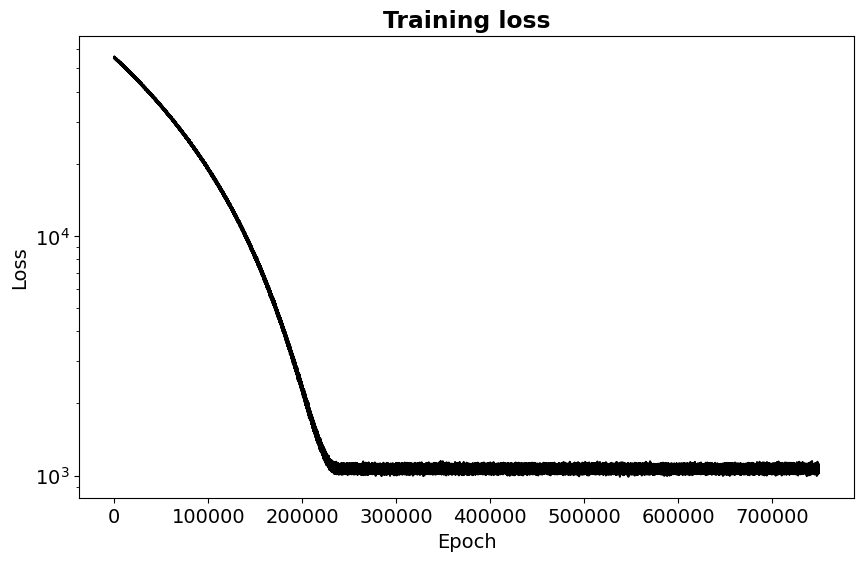

In [ ]:
model.plot_trainingloss(loss_history)

In [ ]:
model.plot_trainingerror(history)

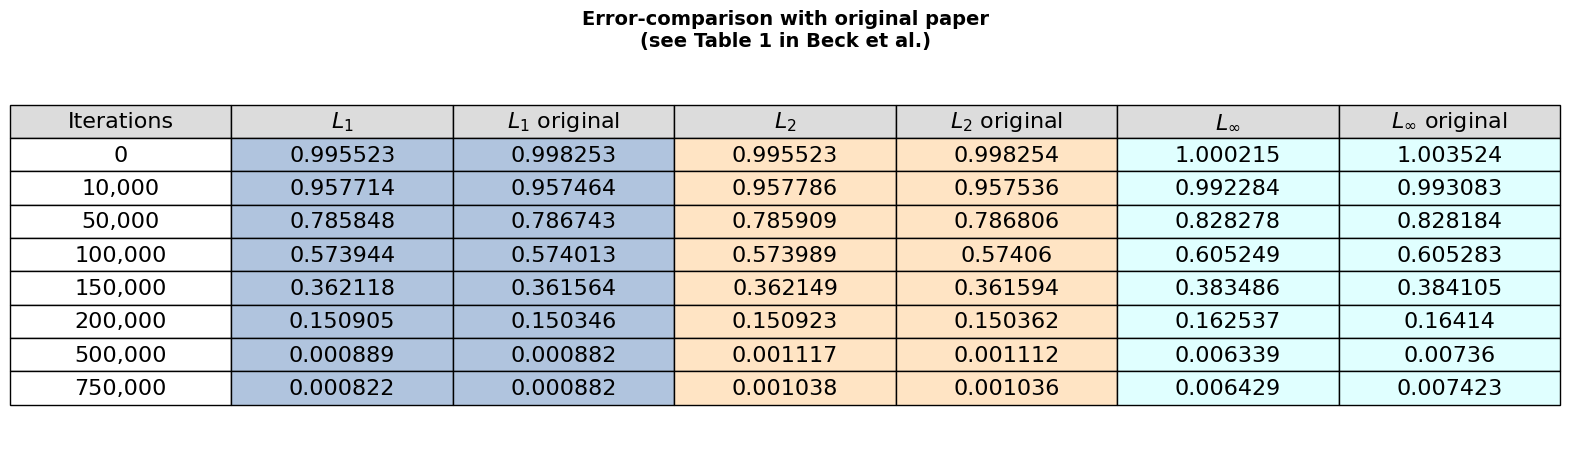

In [ ]:
model.compare_results(history)

Finally we plot a slice of our approximate solution over two input dimensions, as well as its pointwise relative error.

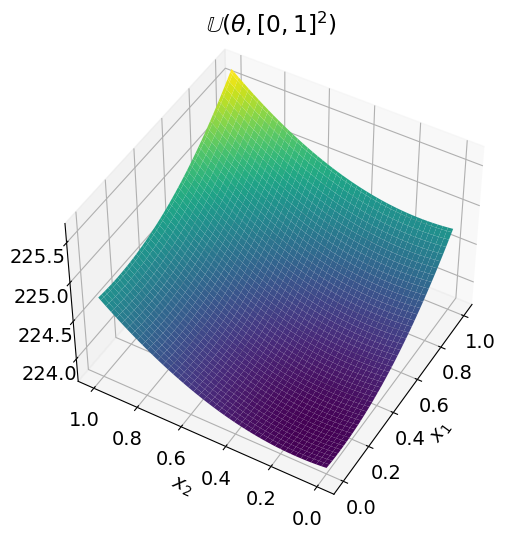

In [ ]:
model.plot_solution(400)

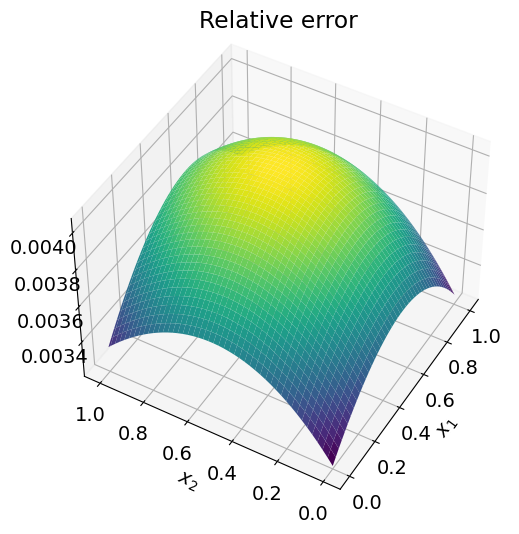

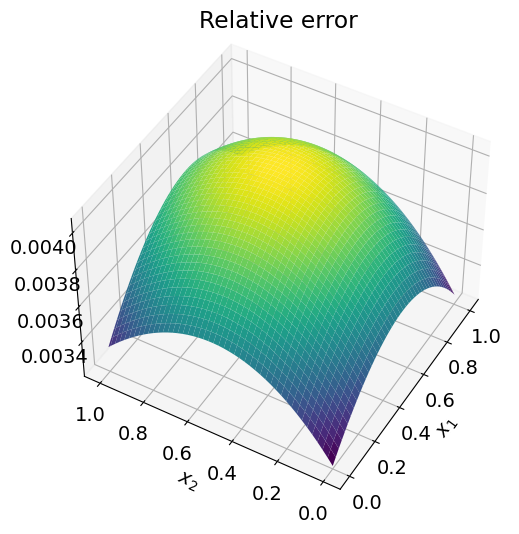

In [ ]:
model.plot_pointwiseerror(400)

### Example 2: Black-Scholes equation (uncorrelated noise)
In this example we solve the Black-Scholes equation for a contingent claim $g\colon\mathbb{R^d\to R}$ whose price depends on 100 uncorrelated risky assets (see Example 4.3 in [Beck et al. (2021)](https://link.springer.com/article/10.1007/s10915-021-01590-0)).
The state space dynamics are given by a geometric $\mathbb{R^d}$-valued Brownian motion with drift $\mu$ and diffusion $\sigma$.
We assume that

- $\mu = -0.05$

- $\sigma = {\rm diag}(0.105, 0.110,\ldots,0.600)\in\mathbb{R^{d\times d}}$

- $g(x) = e^{-rT} \max[(\max_{i=1,\ldots,100}x_i)-K,0]$

- $K = 100$

where $r\in(0,1)$ is the risk-free rate.
This corresponds to the PDE
$$
\begin{aligned}
\partial_tu(t,x) &- \frac{1}{2}\sum^{100}_{i=1} |\sigma_i x_i|^2\partial^2_iu(t,x)
            - \mu \sum^{100}_{i=1} x_i\partial_iu(t,x) = 0 \\
u(0,x) &= e^{-rT} \max\Big[\Big(\max_{i=1,\ldots,100}x_i\Big)-100,0\Big].
\end{aligned}
$$

We approximate the solution on $\mathcal{D}=[90,110]^{100}$.

Note: since the exact solution of the PDE is not available in closed form, we use a Monte Carlo estimate to approximate a reference solution against which we evaluate the accuracy of the algorithm.


In [ ]:
class UncorrelatedBS(KolmogorovSolver):
    def __init__(self):
        super().__init__(a_scalar=90., b_scalar=110.)
        self.mu = tf.constant(-1./20, dtype=DTYPE)
        self.sigma = 1./10 + 1./200 * tf.range(1, self.dim+1, dtype=DTYPE)
        self.r = tf.constant(1./20, dtype=DTYPE)
        self.K = tf.constant(100., dtype=DTYPE)
        self.id = 3

    # State dynamics
    @tf.function
    def _state_step(self, n, X0):
        xi = tf.random.normal((n, self.dim), dtype=DTYPE)
        X1 = X0 * tf.exp((self.mu - 0.5 * tf.square(self.sigma)) * self.T + self.sigma * tf.sqrt(self.T) * xi)
        return X1

    # Terminal condition
    def g(self, x):
        return tf.exp(-self.r * self.T) * tf.maximum(tf.reduce_max(x, axis=1, keepdims=True) - self.K, 0.)

In [ ]:
model = UncorrelatedBS()
Xtest, Ytest = model.test_set_mc()

In [ ]:
history, loss_history = model.experiment(Xtest, Ytest)

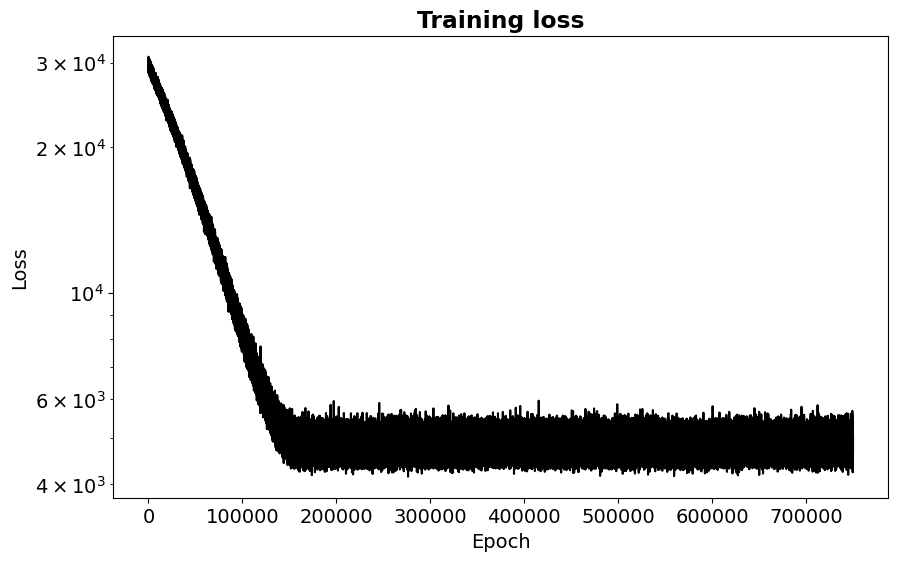

In [ ]:
model.plot_trainingloss(loss_history)

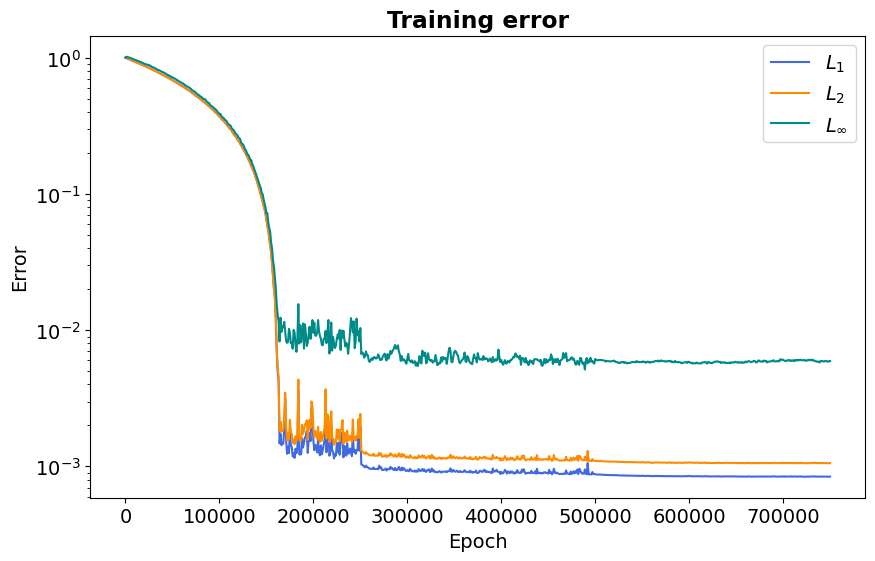

In [ ]:
model.plot_trainingerror(history)

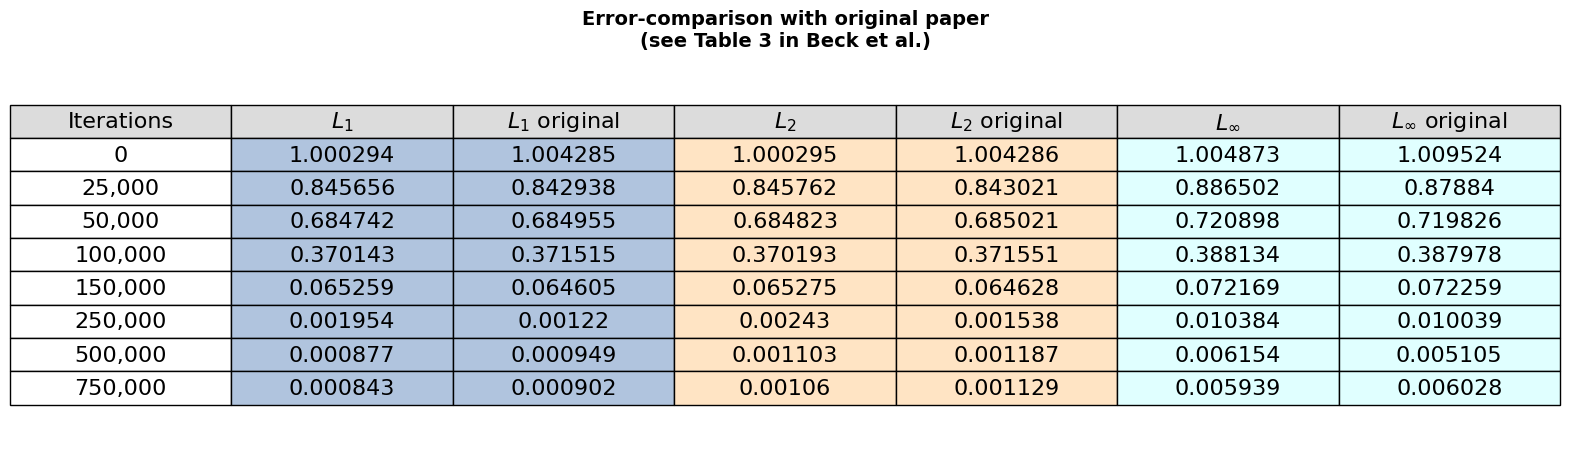

In [ ]:
model.compare_results(history)

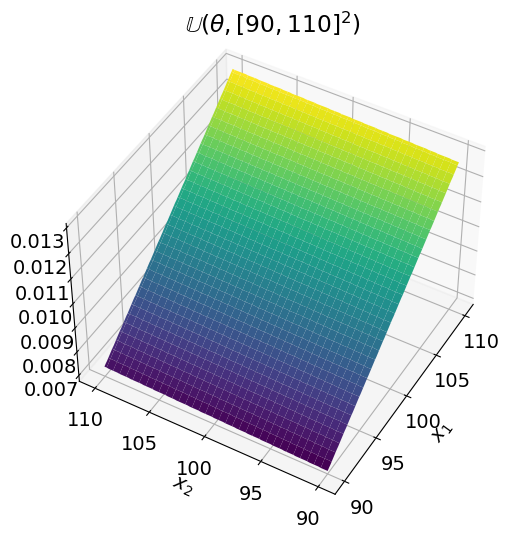

In [ ]:
model.plot_solution(100)

Computing Monte Carlo reference solution...
0 / 2000
100 / 2000
200 / 2000
300 / 2000
400 / 2000
500 / 2000
600 / 2000
700 / 2000
800 / 2000
900 / 2000
1000 / 2000
1100 / 2000
1200 / 2000
1300 / 2000
1400 / 2000
1500 / 2000
1600 / 2000
1700 / 2000
1800 / 2000
1900 / 2000


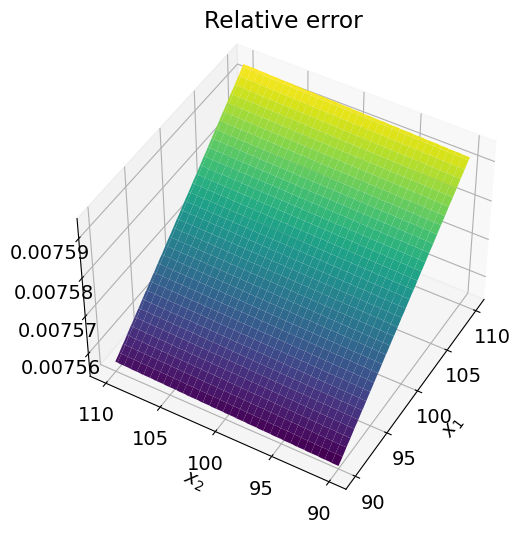

In [ ]:
model.plot_pointwiseerror(100)

### Example 3: Black-Scholes equation (correlated noise)
In this example we solve the Black-Scholes equation for a contingent claim $g\colon\mathbb{R^d\to R}$ whose price depends on 100 risky assets with the following covariance structure (see Example 4.4 in [Beck et al. (2021)](https://link.springer.com/article/10.1007/s10915-021-01590-0)).

We assume that

- $\beta_i = \frac{20+i}{200}$ for all $i\in\{1,\ldots,100\}$

- $Q\in\mathbb{R^{100\times100}}$ is such that $Q_{i}=1$ for all $i\in\{1,\ldots,100\}$ and $Q_{ij} = Q_{ji} = \frac{1}{2}$ for all $i\neq j$

- $\Sigma\in\mathbb{R^{100\times100}}$ is such that $\Sigma_{ii}>0$ for all $i\in\{1,\ldots,100\}$, $\Sigma_{ij} = \Sigma_{ji}=0$ for all $i\neq j$
and $\Sigma\Sigma^{\rm T} = Q$

- $\varsigma_i = (0,\ldots,0,\beta_i\Sigma_{ii},0,\ldots,0)\in\mathbb{R^{100}}$ for all $i\in\{1,\ldots,100\}$

with

- $\mu = -0.05$

- $g(x) = e^{-rT} \max[K-(\min_{i=1,\ldots,100}x_i),0]$

- $K = 110$

where $r\in(0,1)$ is the risk-free rate.

The state space dynamics are given by a geometric $\mathbb{R^d}$-valued Brownian motion with drift $\mu - \frac{1}{2}$ and diffusion $\sigma$.

This is corresponds to the PDE
$$
\begin{aligned}
\partial_tu(t,x) &- \frac{1}{2}\sum^{100}_{i=1} \langle \varsigma_i,\varsigma_j \rangle \,x_i x_j\,\partial^2_{ij}u(t,x)
            - \mu \sum^{100}_{i=1} x_i\,\partial_iu(t,x) = 0 \\
u(0,x) &= e^{-rT} \max\Big[110-\Big(\min_{i=1,\ldots,100}x_i\Big),0\Big].
\end{aligned}
$$

Again we use the proposed scheme to approximate the solution $u(0,\cdot)$ on $\mathcal{D}=[90,110]^{100}$.


In [ ]:
class CorrelatedBS(KolmogorovSolver):
    def __init__(self):
        super().__init__(a_scalar=90., b_scalar=110.)
        self.mu = tf.constant(-1./20, dtype=DTYPE)
        self.Q = tf.linalg.set_diag(tf.ones([self.dim,self.dim])*0.5, tf.ones(self.dim, dtype=DTYPE))
        self.L = np.linalg.cholesky(self.Q + 1e-7 * np.eye(self.dim)).transpose()
        self.sigma_norms = tf.constant(np.linalg.norm(self.L, axis=0), dtype=DTYPE)
        self.sigma = tf.constant(self.L, dtype=DTYPE)
        self.beta = 1./10 + 1./200 * tf.range(1, self.dim+1, dtype=DTYPE)
        self.r = tf.constant(1./20, dtype=DTYPE)
        self.K = tf.constant(110., dtype=DTYPE)
        self.id = 4

    # State dynamics
    @tf.function
    def _state_step(self, n, X0):
        xi = tf.random.normal((n, self.dim), dtype=DTYPE)
        W = tf.matmul(tf.sqrt(self.T) * xi, self.sigma)
        X1 = X0 * tf.exp((self.mu - 0.5 * tf.square(self.beta * self.sigma_norms)) * self.T + self.beta * W)
        return X1

    # Terminal condition
    def g(self, x):
        return tf.exp(-self.r*self.T) * tf.maximum(self.K - tf.reduce_min(x, axis=1, keepdims=True), 0.)

In [ ]:
model = CorrelatedBS()
Xtest, Ytest = model.test_set_mc()

In [ ]:
history, loss_history = model.experiment(Xtest, Ytest)

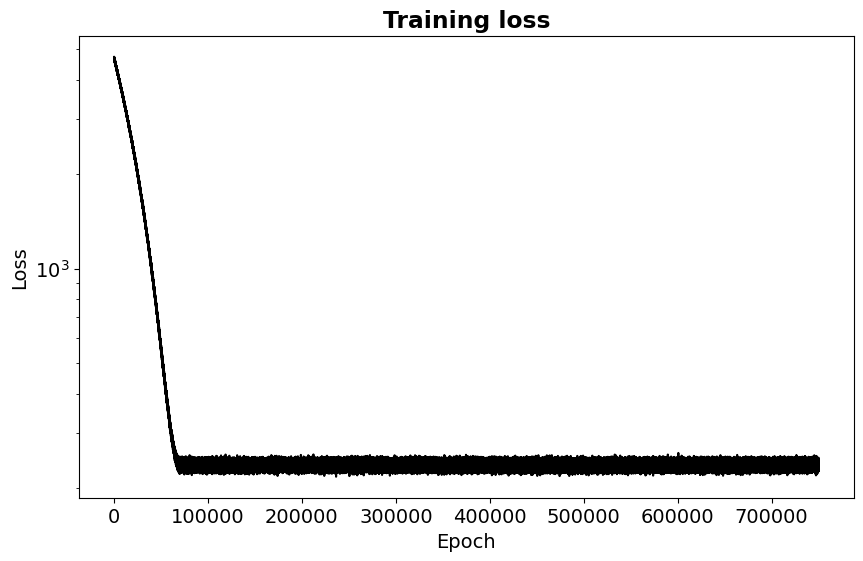

In [ ]:
model.plot_trainingloss(loss_history)

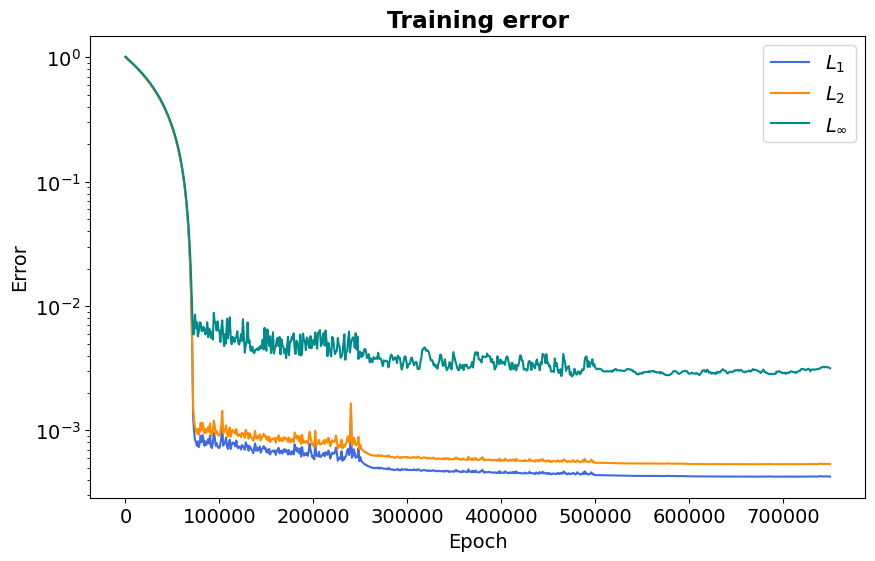

In [ ]:
model.plot_trainingerror(history)

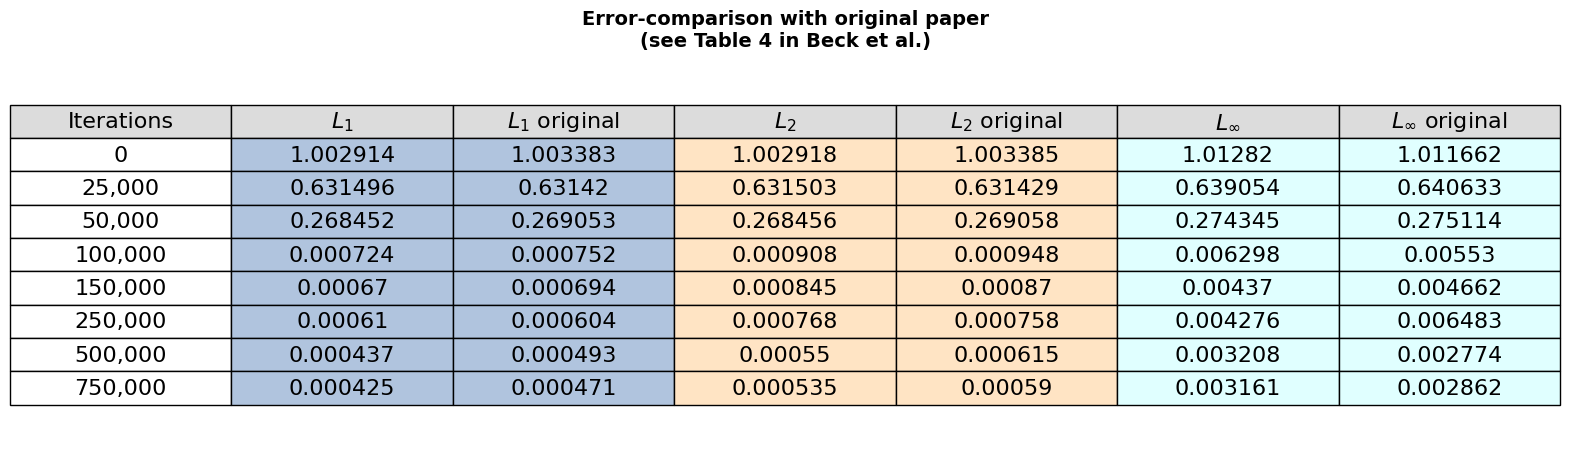

In [ ]:
model.compare_results(history)

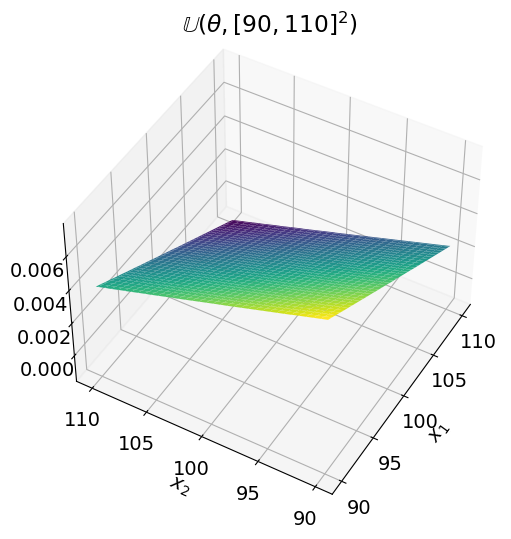

In [ ]:
model.plot_solution(100)

Computing Monte Carlo reference solution...
0 / 2000
100 / 2000
200 / 2000
300 / 2000
400 / 2000
500 / 2000
600 / 2000
700 / 2000
800 / 2000
900 / 2000
1000 / 2000
1100 / 2000
1200 / 2000
1300 / 2000
1400 / 2000
1500 / 2000
1600 / 2000
1700 / 2000
1800 / 2000
1900 / 2000


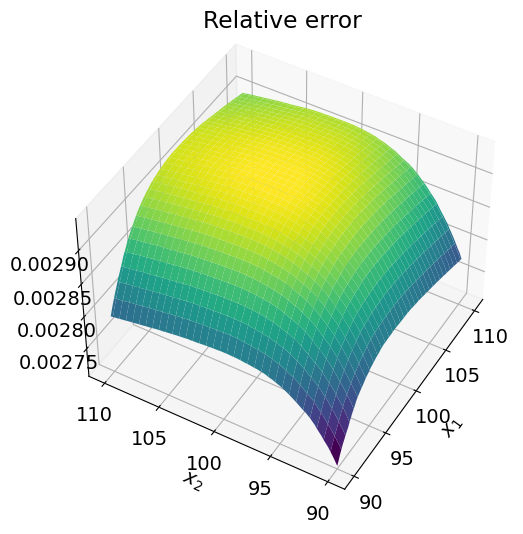

In [ ]:
model.plot_pointwiseerror(100)